In [1]:
from run_nerf import config_parser, create_nerf, render
from load_blender import pose_spherical
import matplotlib.pyplot as plt
import torch
import numpy as np

cuda


In [2]:
# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get config file
config_file = "configs/mutant.txt"
# config_file = "logs/config.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
H, W = int(400), int(400)
focal = 555.555
hwf = [H, W, focal]
K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])
_, render_kwargs_test, _, _, _ = create_nerf(args, 2., 6.)

Found ckpts ['./logs\\mutant\\200000.tar']
Reloading from ./logs\mutant\200000.tar
Not ndc!


## Generate Frame

In [31]:
def generate_input(time, azimuth, elevation):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    render_pose = pose_spherical(azimuth, elevation, 4.0)
    render_time = torch.Tensor([time]).to(device)

    return render_pose, render_time

In [32]:
# genearte
time = .5  # in [0,1]
azimuth = 180  # in [-180,180]
elevation = -20  # in [-180,180]
render_pose, render_time = generate_input(time, azimuth, elevation)

In [39]:
with torch.no_grad():
    ret = render(H, W, K, args.chunk, c2w=render_pose[:3, :4], frame_time=render_time, **render_kwargs_test)

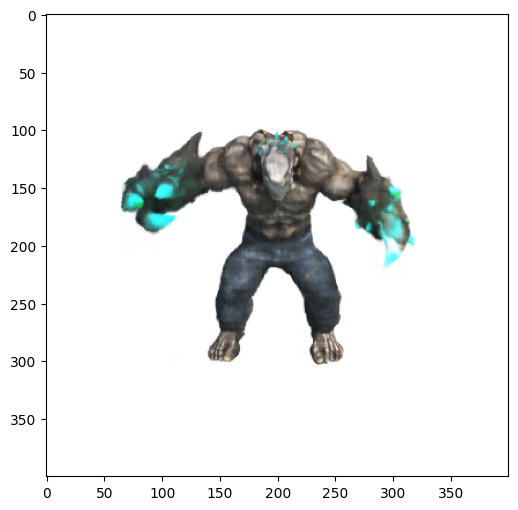

In [40]:
# display
rgb = ret['rgb_fine'] if render_kwargs_test['N_importance'] > 0 else ret['rgb_coarse']
rgb = rgb.detach().cpu().numpy()
plt.figure(2, figsize=(20,6))
plt.imshow(rgb)
plt.show()

## Mesh

In [13]:
def reconstruct(pts, viewdirs, frame_times):
    network_fn = render_kwargs_test['network_fine'] if args.N_importance > 0 else render_kwargs_test['network_fn'] 
    network_query_fn = render_kwargs_test['network_query_fn']
    with torch.no_grad():
        raw = network_query_fn(pts, viewdirs, frame_times, network_fn=network_fn)
    sigma = raw[...,-1].cpu().numpy()
    return sigma
    
with torch.no_grad():
    N = 256
    min_rec, max_rec = -1.2, 1.2
    t = np.linspace(min_rec, max_rec, N)
    query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
    pts = torch.Tensor(query_pts.reshape([-1, N, 3])).to(device)
    N_rays, N_points_per_ray, _ = pts.shape

    viewdirs = torch.zeros([N_rays, 3]).to(device)

    frame_times = torch.zeros([N_rays, 1]).to(device) + .5
    
    sigma = reconstruct(pts, viewdirs, frame_times)
    sigma = sigma.reshape(N, N, N)

In [14]:
sigma.shape

(256, 256, 256)

In [17]:
import mcubes
import trimesh

# reconstruct
threshold = 40  # this is just a randomly found threshold
vertices, triangles = mcubes.marching_cubes(sigma, threshold)
# mesh = trimesh.Trimesh(vertices, triangles)
mesh = trimesh.Trimesh(vertices / N * (max_rec - min_rec) + min_rec, triangles)         # 为什么这样更明亮呢？
mesh = trimesh.smoothing.filter_laplacian(mesh, iterations=3)
mesh.show()